1 Polynomial curve fitting and regularization
-------------------
So far, linear model seems to be too simple to capture the variance in the data, which is actually generated from a flexible sinusoidal model as the latent function. Intuitively, you need more flexible model to capture data with large variantion. However, since you do not really know the latent model which generated the data, you do not want to make our model to be too flexible that leads to overfitting. Why? Because when the model is too flexible and tries to capture all variance in the data, the model would undesirably also capture the **variance in the noise**! It **overfits** the information in the data! 

In this section, you will see how model complexity influence model fitting. This will be illustrated through a **polynomial curve fitting**, where different orders of polynomial model will be trained to fit the above dummy dataset. You will notice how complex higher order polynomial model capture all the variance but overfit the data. To control the complexity of model and avoid overfitting, one option is to impose restrictions upon the model parameters **θ** while train the model to fit the data. A key idea in machine learning based regression, **regularization**, will thus be introduced. **Regularization** is an important technique for you to cope with model complexity. Various versions of **regularization**, such as the *lasso* and *ridge* regressions, are widely adopted.

### 1.0 Polynomial curve fitting

Obviously, during training polynomial models to fit dummy dataset, the complexity of the model is determined by the orders of polynomial terms. For instance, polynomial model with order of 2 with polynomial terms (*x, x^2*) is less complex than that of order 3 with polynomial terms (*x, x^2, x^3*) and thus less flexible to be trained to capture the variance in the data.

Explore the following code to see how model complexty affect the fitting results, and how complex model tries to fit everywhere in the dummy dataset.

Recall how you generated the data.

In [2]:
%matplotlib inline  # In order to plot figures inline in Jupyter Notebook, we need to run this. But please ignore this in Colab.

UsageError: unrecognized arguments: # In order to plot figures inline in Jupyter Notebook, we need to run this. But please ignore this in Colab.


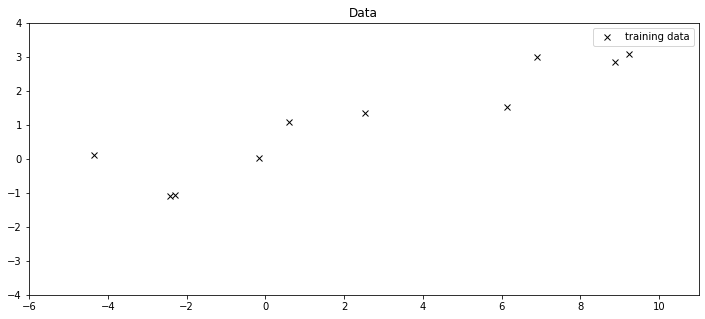

In [3]:
import numpy as np  # You will be using Numpy module
import matplotlib.pyplot as plt  # Module for visualization will also be used

# Define the true function for generating dummy dataset
def func(x):
    # Generate sample dataset from a linearly transformed sinusoidal function: y=sin(x)+0.3*x+e (where 'e' is random noise)
    return np.sin(x) + .3*x

# Define function for generating dummy dataset
def dummyData(func, sample_size, std):
    # Artificially generate input x
    x = np.random.rand(sample_size)[:,None]; x=x*15-5
    # Call function to generate response y
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

# Generate dummy dataset
# 10 data points are created for model training, and another 5 are created to test the accuracy of the model
x_train, y_train = dummyData(func, 10, 0.25)

# Visualize the artificially generated dataset
plt.figure(figsize=(12,5))
plt.xlim([-6., 11])
plt.ylim([-4, 4])
plt.title('Data')
plt.plot(x_train,y_train,'kx',label='training data')
plt.legend()

Recall how you defined functions to train your model and make predictions.

In [4]:
# Define a function to fit a linear model to the dummy data.
def fit(x, y):
    # x : (N, D) np.ndarray
    # y : (N,) np.ndarray
    # Linear fit means a linear model in the form of M(x) = θ1 + θ2x is assumed
    # Or, in the form of matrix multiplication M(X) = θ'X, where
    # X is referred as designed vector/matrix in the form of [1, x]' and θ is [θ1, θ2]'
    X_mat=np.hstack((np.ones(len(x)).reshape(-1,1), x))  # X_mat is a designed matrix
    
    # Given the observed data y, a proper solution of θ to M(x) can be: θ* = argmin (||y - X @ θ||^2_2)
    theta = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)  # If you see an @ in the middle of a line, that's matrix multiplication.
    var = np.mean(np.square(X_mat @ theta - y))
    return theta, var

def predict(x, theta, var, return_std:bool=False):
    X_mat=np.hstack((np.ones(len(x)).reshape(-1,1), x))  # X_mat is a designed matrix
    y = X_mat @ theta
    if return_std:
        y_std = np.sqrt(var) + np.zeros_like(y)
        return y, y_std
    return y


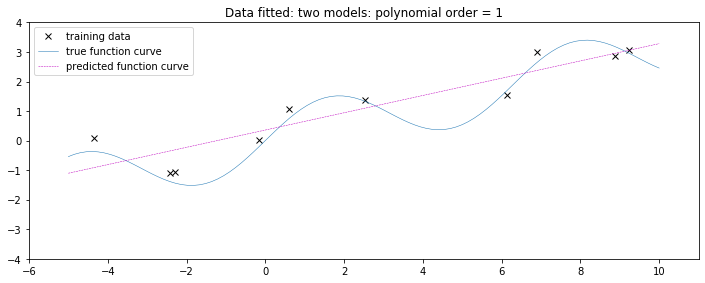

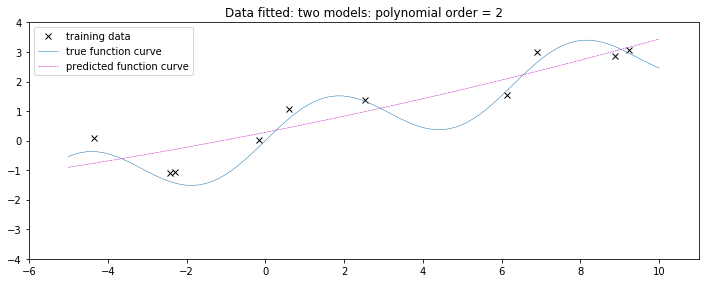

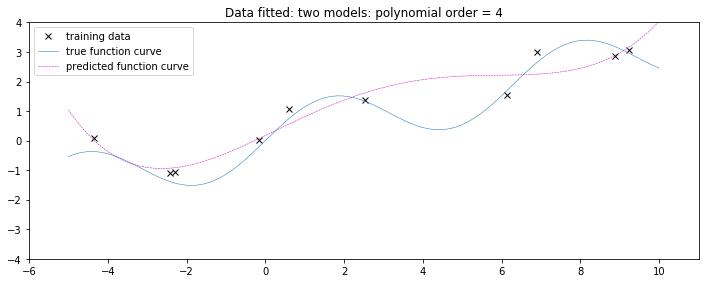

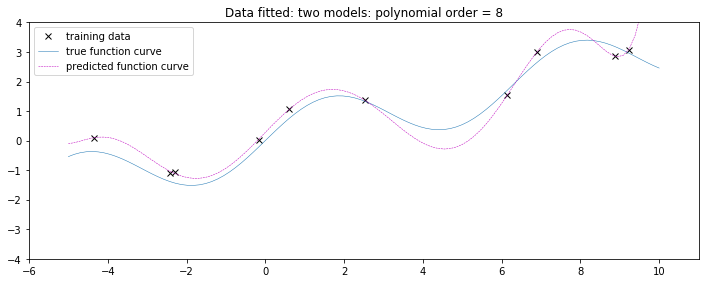

In [6]:
import functools
import itertools

# Define a fuction that project inputs into higher order polynomial inputs. 
# For instance, when degree=3, x becomes to (x, x^2, x^3).
def transform(x, degree):
    # Transforms input array with polynomial features
    # x : (sample_size, n) ndarray
    # Output : (sample_size, 1 + nC1 + ... + nCd) ndarray

    if x.ndim == 1:
        x = x[:, None]
    x_t = x.transpose()
    features = []
    for degree in range(1, degree + 1):
        for items in itertools.combinations_with_replacement(x_t, degree):
            features.append(functools.reduce(lambda x, y: x * y, items))
    return np.asarray(features).transpose()

x_all = np.linspace(-5, 10, 100).reshape(-1,1)
y_true = func(x_all)

for i, deg in enumerate([1, 2, 4, 8]):
    plt.figure(figsize=(12,20))
    plt.subplot(4, 1, i + 1)
    
    x_poly = transform(x_train, deg)  # Project original inputs into polynomial inputs
    weights3, variance3 = fit(x_poly, y_train)  # Fit data as a linear combination of the polynomial inputs
    y_predict3 = predict(transform(x_all, deg), weights3, variance3)  # Prediction
    
    y_true = func(x_all)  # True model values
    
    plt.xlim([-6., 11])
    plt.ylim([-4, 4])
    plt.title('Data fitted: two models: '+'polynomial order = '+str(2**i))
    plt.plot(x_train,y_train,'kx',label='training data')  # Plot dummy dataset data points
    plt.plot(x_all, y_true, linewidth=.5, label='true function curve')  # True model values
    plt.plot(x_all, y_predict3, '--m', linewidth=.5, label='predicted function curve')  # Polynomial data fit
    plt.legend()


### 1.1 Control model complexity, regularization, and feature selection

Given the order of the polynomial terms, the complexity of the model can be restricted or controlled by the parameters of the polynomial terms -- the **θ**. Indeed, there are multiple ways of **regularization** to control the parameters. You can either eliminate some *θ* of the higher order polynomial terms to retain only the lower order terms, or eliminate all **θ**.

To achieve **regularization**, you need to define a new function that can control the impact of model weights **θ** to restrict the influence of terms in **X**. Technically, you can achieve this by adding a **regularization** term to our fitting function already defined in *section 0.1*.

The **regularization term** restricts model weights **θ** within a certain range control the effects of regression terms, such as *(θ<sub>2</sub>, θ<sub>3</sub>,..., θ<sub>n+1</sub>)* of the polynomial terms *(x<sub>1</sub>, x<sub>2</sub>,..., x<sub>n</sub>)*. When the effects of these regression terms, especially the higher order ones, are restricted, the complexity of the model is controlled.

You can of course design different forms of **regularization** to achieve different restriction effects. Popular **regularization** approaches have names such as **ridge regression** and **lasso regression**. The **regularization** term in **ridge regression** is introduced into the OLS loss function in the form of **||θ||^2_2**, thus the value of **θ** is also minimized while minimizing the loss function. It achieves an overall restriction for all **θ** equally, or for instance, for an 8 order polynomial model, *(θ<sub>2</sub>, θ<sub>3</sub>, θ<sub>4</sub>,..., θ<sub>9</sub>)* are all shrinking towards 0. **Lasso regression** imposes a **regularization** term in the form of **||θ||_1**, which eliminates **θ** in a way that some of them are eliminated more significant than the others. Ultimately, **lasso regression** reduces model complexity by deleting regressio terms, and acts as a **variable/feature selection** tool if you consider *(x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub>,..., x<sub>8</sub>)* as features in multivariable regression.

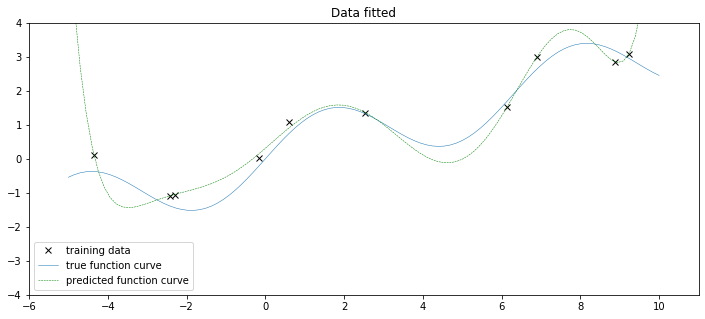

In [7]:
# Here is how you train the linear model using the regularized Ordinary Least Squares (OLS)
# The regularization term restricts θ within ||θ||^2_2, which is known as the ridge regression.
def fitReg(x, y, alpha):
    # x : (N, D) np.ndarray
    # y : (N,) np.ndarray
    # Similar to what has been defined in section 0.2, you need a designed matrix
    X_mat=np.hstack((np.ones(len(x)).reshape(-1,1), x))  # X_mat is a designed matrix
    
    # Now, a regularization term ||θ||^2_2 is introduced to control θ that restricts θ within certain range.
    # The parameter alpha controls the extent of the restriction or regularization.
    # Given the observed y, the solution of θ in section 0.2 becomes: θ* = argmin (||y - X @ θ||^2_2 + alpha * ||θ||^2_2)
    eye = np.eye(np.size(X_mat, 1))
    theta = np.linalg.solve(alpha * eye + X_mat.T @ X_mat, X_mat.T @ y)
    
    #w = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)  # If you see an @ in the middle of a line, that's matrix multiplication.
    var = np.mean(np.square(X_mat @ theta - y))
    return theta, var

deg = 8  # Polynomial model of order 8 already shown above

# Parameter that control the extent of restriction imposed upon model weights θ.
# Please try to experiment with this parameter to see how it affects the model fitting.
# As you can see when alpha is larger than 1e-1, the polynomial model with order 8 is already significantly restricted compared to that in the image above.
alpha = 1e-1

weights, variance = fitReg(transform(x_train, deg), y_train, alpha)

y_predict = predict(transform(x_all, deg), weights, variance)

plt.figure(figsize=(12,5))
plt.xlim([-6., 11])
plt.ylim([-4, 4])
plt.title('Data fitted')
plt.plot(x_train,y_train,'kx',label='training data')
plt.plot(x_all, y_true, linewidth=.5, label='true function curve')
plt.plot(x_all, y_predict, '--g', linewidth=.5, label='predicted function curve')
plt.legend()

C:\Users\Jon\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1595768206432107, tolerance: 0.0022490687535268975
  positive)


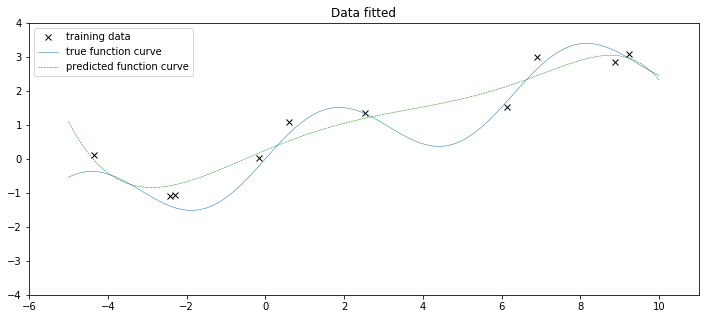

In [8]:
# By adding a regularization term to the loss function of OLS in the form of ||θ||_1, it becomes the lasso regression. 
# And the loss function to solve θ in section 0.2 becomes: θ* = argmin (||y - X @ θ||^2_2 + alpha * ||θ||_1).

# In fact you don't need to write the function to implement every kind of regularized regression as for illustration shown above.
# There are already many great Python modules that implemented these widely used regression techniques.
# For instance, you can directly import the Lasso function provided by the "sklearn" module as shown below.

from sklearn.linear_model import Lasso

# By using Lasso function provided by "sklearn", you don't even have to generate the designed matrix from the input, the function takes care of the original input for you.
# But you still need to create the 8 order regression terms (x, x^2, x^3,..., x^8) by transforming the input to enforce a polynomial model fitting.

deg = 8  # Again, use the polynomial model of order 8 already shown above

# You can directly define your model by calling the Lasso function imported from "sklearn", and set the extent of regularization.
model_lasso = Lasso(alpha=1e-1)  # Again, please try to experiment with this parameter to see how it affects the model fitting.

# Then, fit this model to the data.
model_lasso.fit(transform(x_train, deg), y_train)

# Make predictions every where to show the fitted curve.
y_predict = model_lasso.predict(transform(x_all, deg))

# Plot the data. Does the fitted curve look less complex than it was in section 1.1?
# Remember try to experiment with different alpha.
plt.figure(figsize=(12,5))
plt.xlim([-6., 11])
plt.ylim([-4, 4])
plt.title('Data fitted')
plt.plot(x_train,y_train,'kx',label='training data')
plt.plot(x_all, y_true, linewidth=.5, label='true function curve')
plt.plot(x_all, y_predict, '--g', linewidth=.5, label='predicted function curve')
plt.legend()